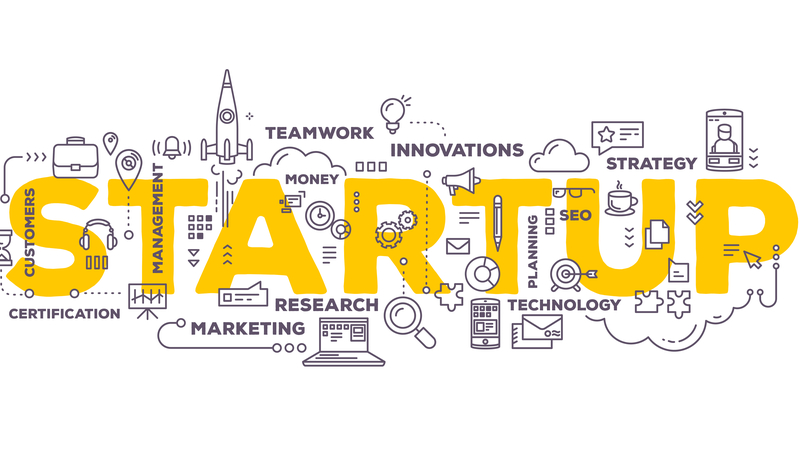

pic credit - google images

# Content
This dataset has funding information of the Indian startups from January 2015 to August 2017. It includes columns with the date funded, the city the startup is based out of, the names of the funders, and the amount invested (in USD). 


# Possible questions which could be answered are:

*     How does the funding ecosystem change with time?
*     Do cities play a major role in funding?
*     Which industries are favored by investors for funding?
*     Who are the important investors in the Indian Ecosystem?
*     How much funds does startups generally get in India?


**Importing libraries**

In [ ]:
import pandas as pd
import numpy as np
import datetime
import re

import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import iplot,init_notebook_mode,plot

init_notebook_mode(connected=True)
data = pd.read_csv("../input/indian-startup-funding/startup_funding.csv",index_col='Sr No')

> **Reading Top 10 data from dataset**

In [ ]:
data.head(10)

> Reading last 10 data from dataset

In [ ]:
data.tail(10)

> Checking the shape of dataset (Row and Columns)

In [ ]:
data.shape

**Printing basic Information of Row and Columns**

In [ ]:
data.info()

> Changing Date Column into Datetime Format

In [ ]:
data.rename(columns={'Date dd/mm/yyyy':'Date','Amount in USD':'Fund'},inplace=True)

def DateFormatting(dates):
    try:
        date = pd.to_datetime(dates,format='%d/%m/%Y')
    except(Exception)as e:
        return pd.to_datetime("05/07/2018",format='%d/%m/%Y') if(dates == '05/072018') else None
        return pd.to_datetime("07/01/2015",format='%d/%m/%Y') if(dates == '15-01-07 00:00:00') else None
        return pd.to_datetime("10/7/2015",format='%d/%m/%Y') if(dates == '\\xc2\\xa010/7/2015') else None
        return pd.to_datetime("22/01/2015",format='%d/%m/%Y') if(dates == '22/01//2015') else None
    else:
        return date
        
    

data['Date'] = data['Date'].apply(DateFormatting)

> Converting Fund Column Datatype  Object into Float

In [ ]:
exceptionList =['unknown','Undisclosed','undisclosed']
def ConvertingDataIntoFloat(money):
    match = ''
    if((type(money)!=float)):
        match = re.match(r'(\\\\xc2\\\\xa0)(.*)',money)
    try:
        if(money not in exceptionList and (type(money)!=float) and bool(re.match(r'\\\\xc2\\\\xa0.*',money))==False):
            if('+' in money and (',' in money)):
                return float(money.replace('+','').replace(',',''))
            elif('+' in money and (',' in money)!=True):
                return float(money.replace('+',''))
            elif(',' in money):
                return float(money.replace(',',''))
        elif(money in exceptionList):
            return np.nan
        elif(match):
            if(match.group(2)=='N/A'):
                return np.nan
            else:
                return float(match.group(2).replace(',',''))
    except(Exception)as e:
        print(e,end='\t')
        print(money)
    else:
        if(type(money)==str):
            return float(money)
        else:
            return money
        
data['Fund'] = data['Fund'].apply(ConvertingDataIntoFloat)

> Now lets Check the Null value in Each Column

In [ ]:
for col in data.columns:
    print("({1:.2f}%) -- {2}  value(s) are NaN in {0} Column".format(col,data[col].isna().sum()/len(data)*100,data[col].isna().sum()))
    

To Fill Missing Values in data set we have multiple approach Like 
* Forword Fill
* Backword Fill
* Mean,Median and Mode Fill
* There is Dedicated Library "Imputer" in Sklearn which provide some more method

but In this type of domain we can't use those because Funding depends upon mutliple factor (User-base, Company's Growth rate,Competition in market and etc).

*(we will use all those method in next Version)

So we Simply drop those NaN value and corresponding row as per Fund Column

In [ ]:
data2 = data[data['Fund'].isna()!=True]
for col in data2.columns:
    print("({1:.2f}%) -- {2}  value(s) are NaN in {0} Column".format(col,data2[col].isna().sum()/len(data2)*100,data2[col].isna().sum()))

Some company are listed as **CarDekho**.com and **CarDekho** so we will extract only the company name

In [ ]:
data2['City  Location'] = [re.sub(r'\\\\xc2\\\\xa0','',str(x)) if(('\\\\xc2\\\\xa' in str(x)) and (type(x)!=float)) else x for x in data2['City  Location'].values]

data2['Startup Name'] = [re.search(r'([\w\s]*).(in|com)',str(do)).group(1) if(('.in' in str(do)) or ('.com' in str(do))) else str(do) for do in data2['Startup Name'] ]

# All finished with pre-processing now lets start doing EDA

In [ ]:
fundData = data2.sort_values("Fund",ascending=False,axis=0,na_position='last')# we can also do inplace = True

In [ ]:
fig = px.line(fundData,x='Date',y='Fund')

fig.show()

> Rapido Bikes is in the final stages of closing a $50 million funding round, led by private equity firm WestBridge Capital, showcasing the growing investor interest in the Indian tech-focused mobility sector. -->(According to Economic Times Report)

In [ ]:
fundData[fundData['Fund']>1000000000]

So in the data set there might be an error which show 3.9B $ 

we will convert those 3.9B$ to 50Million $

We will delete the Remark Column which have more than 85%+ Missing values

In [ ]:
fundData.loc[fundData['Fund']==3.900000e+09,'Fund'] = 50000000
fundData.drop('Remarks',1,inplace=True)
FinalData = fundData
FinalData.set_index('Date',inplace=True)

# 1 - > How does the funding ecosystem change with time?

In [ ]:
MonthlyMeanFunding = pd.DataFrame()
MonthlyMeanFunding['Avg Funding of Month'] = FinalData['Fund'].resample('M').mean()

data1 = go.Bar(x=MonthlyMeanFunding.index,
              y=MonthlyMeanFunding['Avg Funding of Month'],
              text=MonthlyMeanFunding.index)

lay = go.Layout(title='Monthly Avg Funding',
          xaxis=dict(title='Month and Year'),
          yaxis = dict(title='Avg Funding'))

fig = dict(data=data1,layout=lay)
iplot(fig)

#seems to be there is Quaterly funding

In [ ]:
QuarterMeanFunding = pd.DataFrame()
QuarterMeanFunding['Quarters'] = FinalData['Fund'].resample('Q').mean()

data1 = go.Bar(
    x=QuarterMeanFunding.index,
    y=QuarterMeanFunding['Quarters']
)

lay = go.Layout(title='Quarterly Mean Funding',
               xaxis=dict(title='Quarters'),
               yaxis=dict(title='Mean Funding'))

fig = dict(data=data1,layout=lay)
iplot(fig)

**In Quarterly we can see that there are actually growth in Funding year-by-year**

**We can't say it is a trendy growth but its seem's like every quarter have seasonlity growth**

In [ ]:
#How much funds does startups generally get in India ?(maximum funding, minimum funding , average funding and number of fundings)

# How much funds does startups generally get in India?

In [ ]:
totalFunding = FinalData['Startup Name'].value_counts()

fig = px.scatter(totalFunding,x=totalFunding.index,y=totalFunding[0:],title='Total Number of Funding to Each Company',
                labels={
                    'index':"Company's Name",
                    'y':'Total No. of Times Funding Received'
                })

fig.show()

**From above graph we can say that only 10 startup got more than 5 times funding**

In [ ]:
company = FinalData.groupby(['Startup Name'])['Fund'].sum()
allMerge = pd.merge(totalFunding,company,on=totalFunding.index)
allMerge.rename(columns={'key_0':"Startup Name",'Startup Name':'Total Times Funding','Fund':'TotalFund'},inplace=True)

fig = px.scatter(allMerge,x='Startup Name',y='TotalFund',hover_data=allMerge,title='Total Fund VS Startup Name')

fig.show()

Only Few company have got More than 1B+ Dollar Funding

In [ ]:
# finding Min and Max funding in Startup

fig = px.box(allMerge['TotalFund'])

fig.show()



* Min Funding = 16k
* Quartile 1 = 431k
* Median = 1.5M
* Quartile 3 = 8M
* Upper Fence = 19.4M

# Which industries are favored by investors for funding?

>We will prefer Industry Vertical Column because it have only 7% nan value

We will divide funding Mean in different size 
* Above 100M+
* Between 100M to 50M
* Below 50M

In [ ]:
industryType = FinalData.groupby(['Industry Vertical'])['Fund'].mean()

AboveM = industryType[industryType>100000000]
fig = px.scatter(x = AboveM.index,y=AboveM,color=AboveM,size=AboveM,title='Funding (100M+) Vs Industry Type',
                labels={
                    'x':'Industry Type',
                    'y':'Total Funding'
                })
fig.show()

**Above Graph show which industries have got 100M+ Funding**

In [ ]:
LessM = industryType[(industryType<100000000) & (industryType>50000000)]

fig = px.scatter(x=LessM.index,y=LessM,size=LessM,color=LessM,title='Funding (100M - 50M) Vs Industry Type',
                labels={
                    'x':'Industry Type',
                    'y':'Total Funding'
                })
fig.show()

In [ ]:
LessM = industryType[industryType<50000000]#less than 50M

fig = px.scatter(x=LessM.index,y=LessM,size=LessM,color=LessM,title='Funding (Below 50M) Vs Industry Type',
                labels={
                    'x':'Industry Type',
                    'y':'Total Funding'
                })
fig.show()

# Do cities play a major role in funding?

In [ ]:
totalStartupInCity = FinalData['City  Location'].value_counts()

fig = px.pie(totalStartupInCity,names=totalStartupInCity.index
             ,values=totalStartupInCity.values,title='Total Number of Startup in Cities',height=800)
fig.update_traces(textposition='inside',textinfo='percent+label')

fig.show()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

lessThan10 = totalStartupInCity[totalStartupInCity<10]
GreaterThan10 = totalStartupInCity[totalStartupInCity>10]

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=lessThan10.index, values=lessThan10, name="10<"),
              1, 1)
fig.add_trace(go.Pie(labels=GreaterThan10.index , values=GreaterThan10, name="10+",marker = {"colors":lessThan10}),
              1, 2)


fig.update_traces(hole=.4, hoverinfo="label+percent+name")
fig.update_traces(textposition='inside',textinfo='percent+label')

fig.update_layout(
    title_text="City With Number of  Startup",
    annotations=[dict(text='10<', x=0.18, y=0.5, font_size=20, showarrow=False),
                 dict(text='10+', x=0.82, y=0.5, font_size=20, showarrow=False)])
fig.show()

We can see cities like 
* Bangalore
* Mumbai
* Delhi
* Gurgaon
* Bangaluru

have maximum number of startup then followed by 
* Chennai
* Hyderabad
* Pune,etc

# Who are the important investors in the Indian Ecosystem?

In [ ]:
from wordcloud import WordCloud

invester = FinalData["Investors Name"][~pd.isnull(FinalData["Investors Name"])]

wordCloud = WordCloud(width=500,height= 300).generate(' '.join(invester))

plt.figure(figsize=(19,9))

plt.axis('off')
plt.title("Investers Name")
plt.imshow(wordCloud)
plt.show()


In [ ]:
#lets get top ten investers 
investers = FinalData['Investors Name'].value_counts().head(20)

fig = px.bar(x=investers.index,y=investers,color=investers.index,title='Top Investers',
            labels={
                'x':"Investers Name",
                'y':'Number of Investment'
            })

fig.show()

Above Bar graph show top 20 Investers in Indian Funding Ecosystem

# What are different types of funding for startups ?

In [ ]:
investType = FinalData['InvestmentnType'].value_counts()
wordCloud = WordCloud(width=500,height=200).generate(' '.join(investType.index[0:]))

plt.figure(figsize=(19,9))
plt.imshow(wordCloud)
plt.title('Investment Type',fontsize=20)
plt.axis('off')
plt.show()

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objs as go

highInvestType = investType[investType>12]
lowInvestType = investType[investType<12]

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(labels=highInvestType.index, values=highInvestType, name="10<"),
              1, 1)
fig.add_trace(go.Pie(labels=lowInvestType.index,values=lowInvestType, name="10+",marker = {"colors":highInvestType}),
              1, 2)



fig.update_traces(hole=.4, hoverinfo="label+percent+name")
fig.update_traces(textposition='inside',textinfo='percent+label')


fig.update_layout(
    title_text="City With Number of  Startup",
    annotations=[dict(text='Pie-1', x=0.18, y=0.5, font_size=20, showarrow=False),
                 dict(text='Pie-2', x=0.82, y=0.5, font_size=20, showarrow=False)])

fig.show()

It's seems like 
* Seed Funding
* Private Equity 
have major type of funding in Indian Funding Ecosystem

If your guys have any suggestion(s) or question please leave comment below.

Your comments and suggestion(s) will help me to improvise my Skill 